# DSCI 100 - Course Project Proposal

Title: Predicting Credit Card Default

Group 10: Berkay Talha Acar, Stephen Pon

# Introduction 

The dataset we will use is called “default of credit card clients”. It is credit card data collected from Taiwan by Chung Hua University, Taiwan. A credit default is when a client fails to repay their debt, interest or principal, on a credit card loan. A default can occur when a borrower is
unable to make timely payments, misses payments, or avoids/stops making payments. Default risks are often calculated well in advance by creditors such as banks who set a limit on the clients’ debt. 

With this data, we intend to build a K nearest neighbors classification model that can predict whether a subset of clients with a university education will default based on various credit risk metrics.

# Preliminary Exploratory Data Analysis

After the appropriate libraries are downloaded, the dataset can be read from the web into R as follows:

In [1]:
library(tidyverse)
library(readxl)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following object is masked from ‘package:tidyr’:

    matches


Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────

In [2]:
set.seed(19)
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
download.file(url, "credit_default.xls")
cd <- read_excel("credit_default.xls", skip = 1)
head(cd)

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,20000,2,2,1,24,2,2,-1,-1,⋯,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,⋯,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,⋯,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,⋯,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,⋯,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,50000,1,1,2,37,0,0,0,0,⋯,19394,19619,20024,2500,1815,657,1000,1000,800,0


To clean our dataset, we will first remove the spaces in column names and filter for university educated individuals. 

In [3]:
colnames(cd) <- make.names(colnames(cd))
cd_university <- cd %>%
                filter(EDUCATION == 2)
head(cd_university)

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,20000,2,2,1,24,2,2,-1,-1,⋯,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,⋯,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,⋯,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,⋯,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,⋯,20940,19146,19131,2000,36681,10000,9000,689,679,0
8,100000,2,2,2,23,0,-1,-1,0,⋯,221,-159,567,380,601,0,581,1687,1542,0


Next, we randomly sample 5000 rows from our dataset, rename and factor our classification variable, and create our predictor variables which results in our initial dataframe.

In [4]:
rows <- sample(nrow(cd_university))
df <- cd_university[rows, ]

cd_5000_init <- slice(df, 1:5000) %>%
        rename(default_nm = default.payment.next.month) %>%
        mutate(default_nm = as_factor(default_nm)) %>%
        mutate(pay_avg = (PAY_AMT1 + PAY_AMT2 + PAY_AMT3 + PAY_AMT4 + PAY_AMT5 + PAY_AMT6)/6) %>%
        mutate(bill_avg = (BILL_AMT1 + BILL_AMT2 + BILL_AMT3 + BILL_AMT4 + BILL_AMT5 + BILL_AMT6))
head(cd_5000_init)

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_nm,pay_avg,bill_avg
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
16487,120000,2,2,1,54,0,0,0,0,⋯,80597,3072,3074,2887,2774,2871,3000,0,2946.333,504980
20984,20000,1,2,2,34,2,2,2,0,⋯,19232,3500,0,1500,805,7000,542,1,2224.500,116845
9773,120000,1,2,2,39,1,-1,2,2,⋯,0,1170,0,0,0,0,0,0,195.000,1560
16232,480000,2,2,2,34,0,0,0,0,⋯,209218,18231,20010,13013,11209,9010,162510,1,38997.167,2310604
6078,100000,2,2,2,26,0,0,0,-1,⋯,11329,1227,1150,1600,8000,5000,0,0,2829.500,72704
10469,240000,2,2,2,28,0,0,0,0,⋯,83742,6000,5000,4000,4000,4000,3000,0,4333.333,673434


Here, we split our data into training (75%) and testing (25%) datasets. We will only use the training set for our exploratory analysis.

In [5]:
cd_split <- initial_split(cd_5000_init, prop=0.75, strata=default_nm)
cd_training <- training(cd_split)
cd_testing <- testing(cd_split)

Here, we create our variables of interest. `usage_cdt` and `pmt` represent, on average, the client's bills and payments as a proportion of their available credit card limit. 

In [6]:
cd_5000 <- cd_training %>%
        mutate(payment_to_bill_ratio = pay_avg/bill_avg) %>%  # the ratio of their average payment to average bill    
        mutate(usage_cdt = bill_avg/LIMIT_BAL) %>% # to see how much of their balance they use 
        mutate(pmt = pay_avg/LIMIT_BAL) %>% # to see how much of their balance they pay
        mutate(diff_usage_pmt = usage_cdt - pmt)
head(cd_5000)

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_nm,pay_avg,bill_avg,payment_to_bill_ratio,usage_cdt,pmt,diff_usage_pmt
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
16487,120000,2,2,1,54,0,0,0,0,⋯,2774,2871,3000,0,2946.333,504980,0.005834555,4.208167,0.02455278,4.183614
20984,20000,1,2,2,34,2,2,2,0,⋯,805,7000,542,1,2224.500,116845,0.019038042,5.842250,0.11122500,5.731025
6078,100000,2,2,2,26,0,0,0,-1,⋯,8000,5000,0,0,2829.500,72704,0.038918079,0.727040,0.02829500,0.698745
10469,240000,2,2,2,28,0,0,0,0,⋯,4000,4000,3000,0,4333.333,673434,0.006434682,2.805975,0.01805556,2.787919
12291,50000,1,2,2,39,0,0,0,0,⋯,1000,2000,1000,0,1834.167,105433,0.017396514,2.108660,0.03668333,2.071977
21703,50000,2,2,2,26,2,0,0,0,⋯,187,185,0,0,775.500,144098,0.005381754,2.881960,0.01551000,2.866450


We calculate the means of the variables of interest, grouping by default status where 1 represents default and 0 indicates non-default status. `mean_pay0` represents the average number of payments that are owed or have been paid for the two groups in the last period of available data. Negative values indicate the average client is ahead on payments and positive indicates they are behind. 

`mean_diff_usage_pmt` measures the average difference between the ratio of bills to limit and payments to limit. In theory, the greater the difference, the more an individual is spending and the less they are paying. Notice that credit limit for the non-default group is significantly larger but the average bill only slightly larger compared to those who default. This means those in the default group use, on average, a larger proportion of their available credit.

In [7]:
cd_5000_means <- cd_5000 %>%
                group_by(default_nm) %>%
                summarize(n = n(),
                         mean_pay0 = mean(PAY_0, na.rm = TRUE),
                         mean_limit = mean(LIMIT_BAL, na.rm = TRUE),
                         mean_bill = mean(bill_avg, na.rm = TRUE),
                         mean_pay = mean(pay_avg, na.rm = TRUE),
                         mean_usage_cdt = mean(usage_cdt, na.rm = TRUE),
                         mean_pmt = mean(pmt, na.rm = TRUE),
                         mean_diff_usage_pmt = mean(diff_usage_pmt, na.rm = TRUE)
                         )
cd_5000_means

`summarise()` ungrouping output (override with `.groups` argument)



default_nm,n,mean_pay0,mean_limit,mean_bill,mean_pay,mean_usage_cdt,mean_pmt,mean_diff_usage_pmt
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2871,-0.1055381,155249.0,281498.6,5110.807,2.452993,0.04230372,2.410690
1,879,0.8088737,112241.2,283632.1,3216.366,3.052219,0.03698845,3.015231


Now, we can take a look at some of the columns we created by selecting the ones we are interested in. 

In [8]:
# Now let's take a look at some of the columns we created 
cd_5000_select <- cd_5000 %>%
                select(LIMIT_BAL, PAY_0, bill_avg, pay_avg, usage_cdt, pmt, diff_usage_pmt, default_nm)
head(cd_5000_select) 

LIMIT_BAL,PAY_0,bill_avg,pay_avg,usage_cdt,pmt,diff_usage_pmt,default_nm
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
120000,0,504980,2946.333,4.208167,0.02455278,4.183614,0
20000,2,116845,2224.500,5.842250,0.11122500,5.731025,1
100000,0,72704,2829.500,0.727040,0.02829500,0.698745,0
240000,0,673434,4333.333,2.805975,0.01805556,2.787919,0
50000,0,105433,1834.167,2.108660,0.03668333,2.071977,0
50000,2,144098,775.500,2.881960,0.01551000,2.866450,0


Here, we plot the average bill against the average payment. If an individual is keeping up with payments, we would expect to see that their bills and payments are roughly equal. For those in default, their bills are much larger than payments, this is reflected in the visualization as the blue dots are distributed more horizontally compared to the orange.

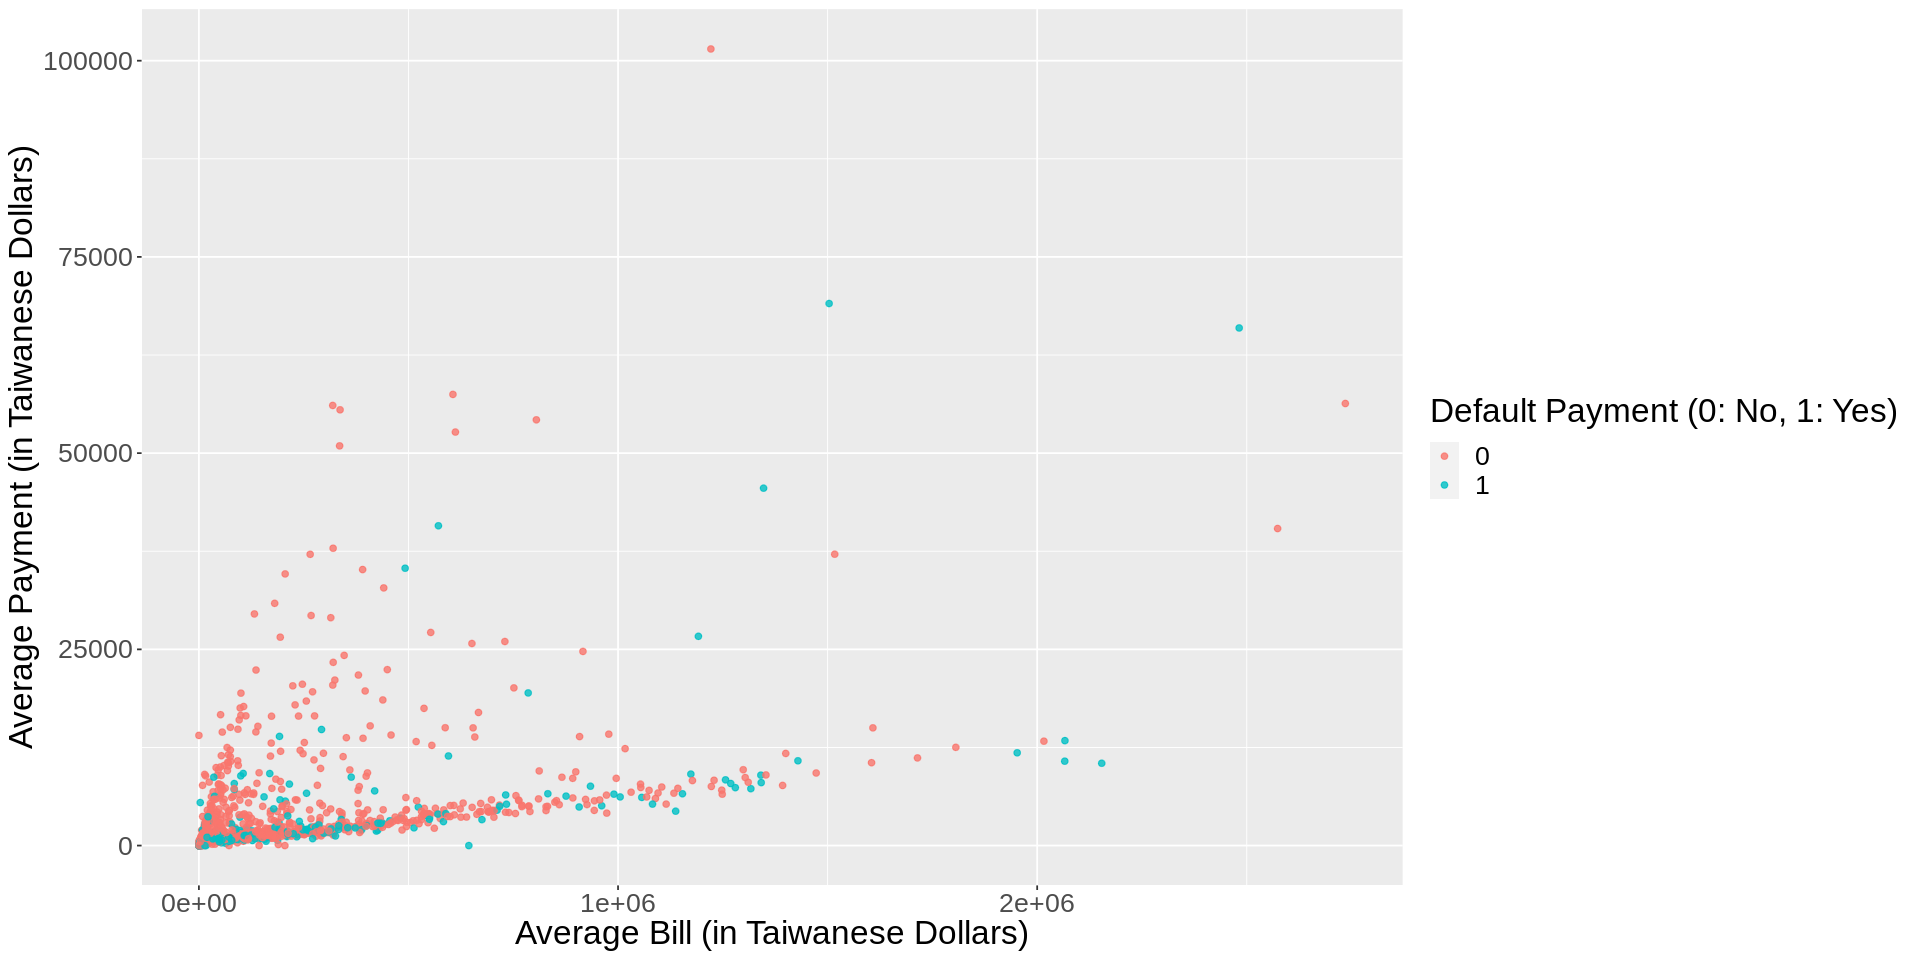

In [9]:
options(repr.plot.width = 16, repr.plot.height = 8)
pay_bill_plot <- cd_5000_select %>%
                slice(1:1000) %>% # to avoid overplotting
                ggplot(aes(x = bill_avg, y = pay_avg, color = default_nm))+
                geom_point(alpha = 0.8)+
                labs(x = "Average Bill (in Taiwanese Dollars)", y = "Average Payment (in Taiwanese Dollars)", color = "Default Payment (0: No, 1: Yes)")+
                theme(text = element_text(size = 20))
pay_bill_plot

We plot bill to credit limit `usage_cdt` against payment to credit limit `pmt`. Notice that those who do not default are located near the origin meaning that they spend little and also pay little whereas those who default spend a lot and pay little.

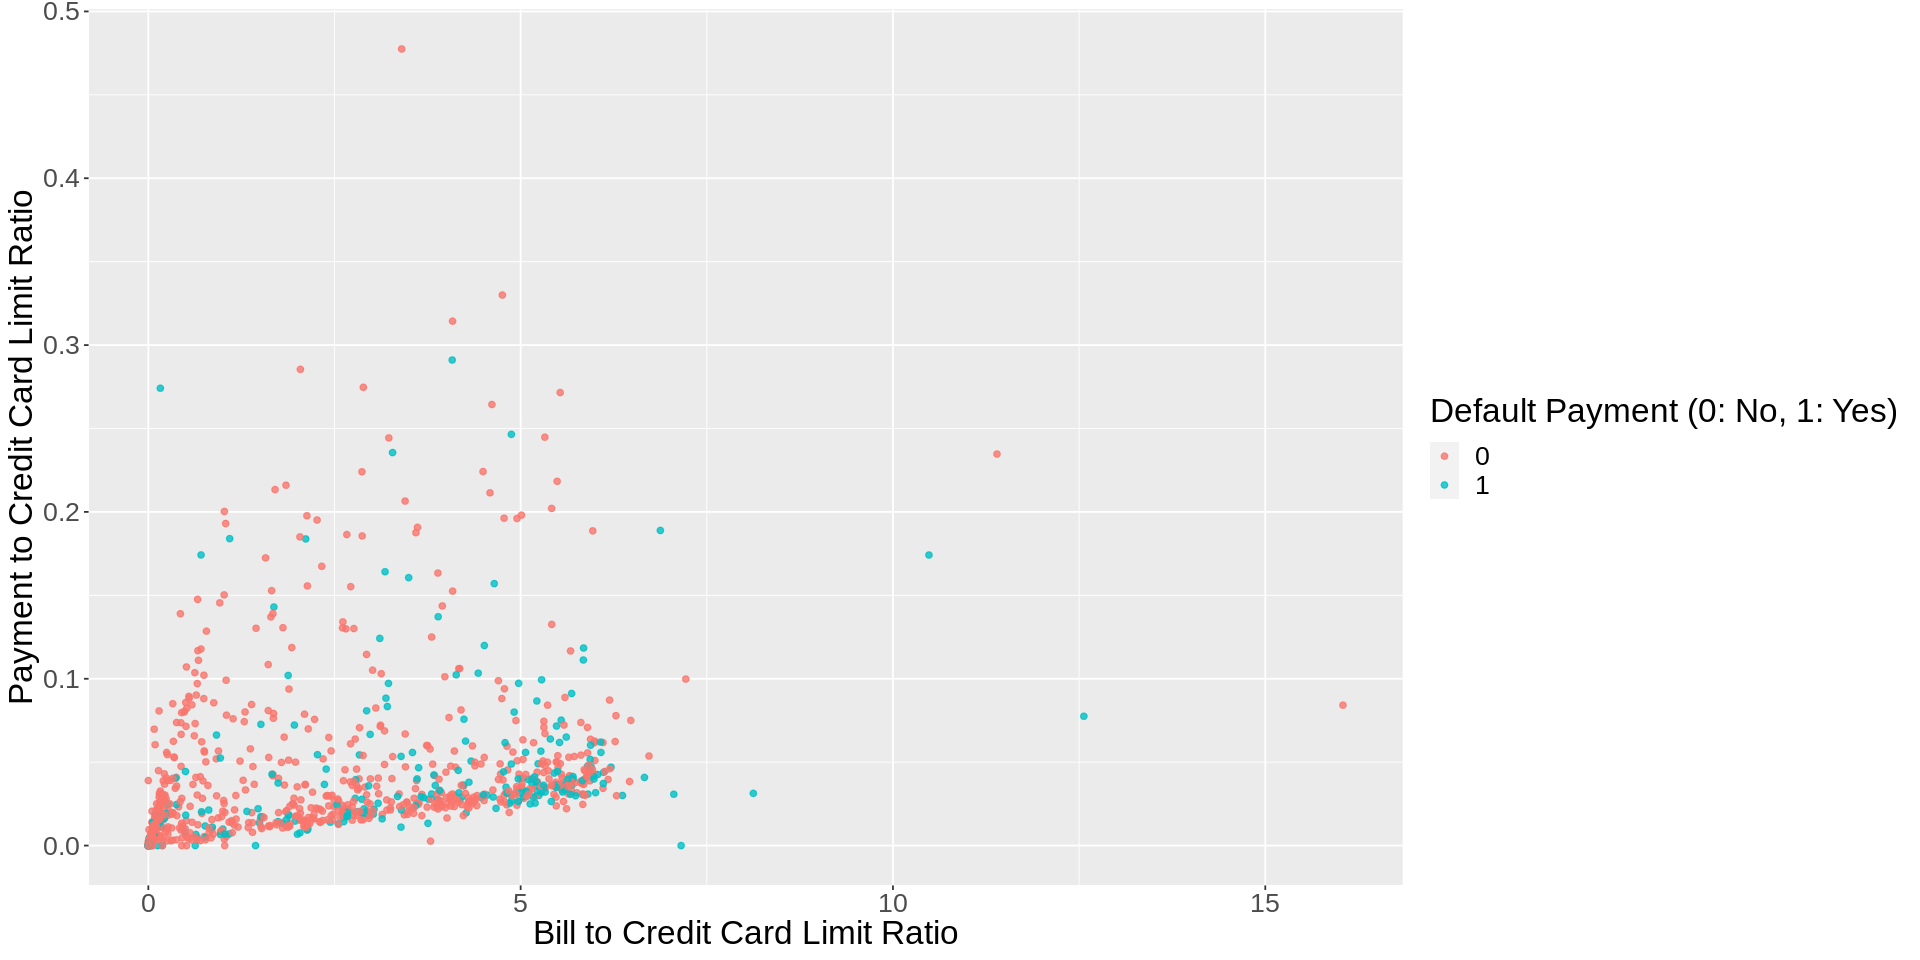

In [10]:
options(repr.plot.width = 16, repr.plot.height = 8)
usage_pmt_plot <- cd_5000_select %>% # GOOODDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD
                slice(1:1000) %>% 
                ggplot(aes(x = usage_cdt, y = pmt, color = default_nm))+
                geom_point(alpha = 0.8)+
                labs(x = "Bill to Credit Card Limit Ratio", y = "Payment to Credit Card Limit Ratio", color = "Default Payment (0: No, 1: Yes)")+
                theme(text = element_text(size = 20))
usage_pmt_plot

Here, we can see the proportions of default payments for different credit card limits. We can see that the proportion of people who default their payment seem to decrease between 0 NTD and 3e+05 NTD. We show the proportions of default payments for different credit limits, `LIMIT_BAL`. We can see that the proportion of those that default decreases as credit limit increases. This is because credit limits are themselves a function of credit risk analyzed by the bank where lower limits are assigned to those who are more likely to default.

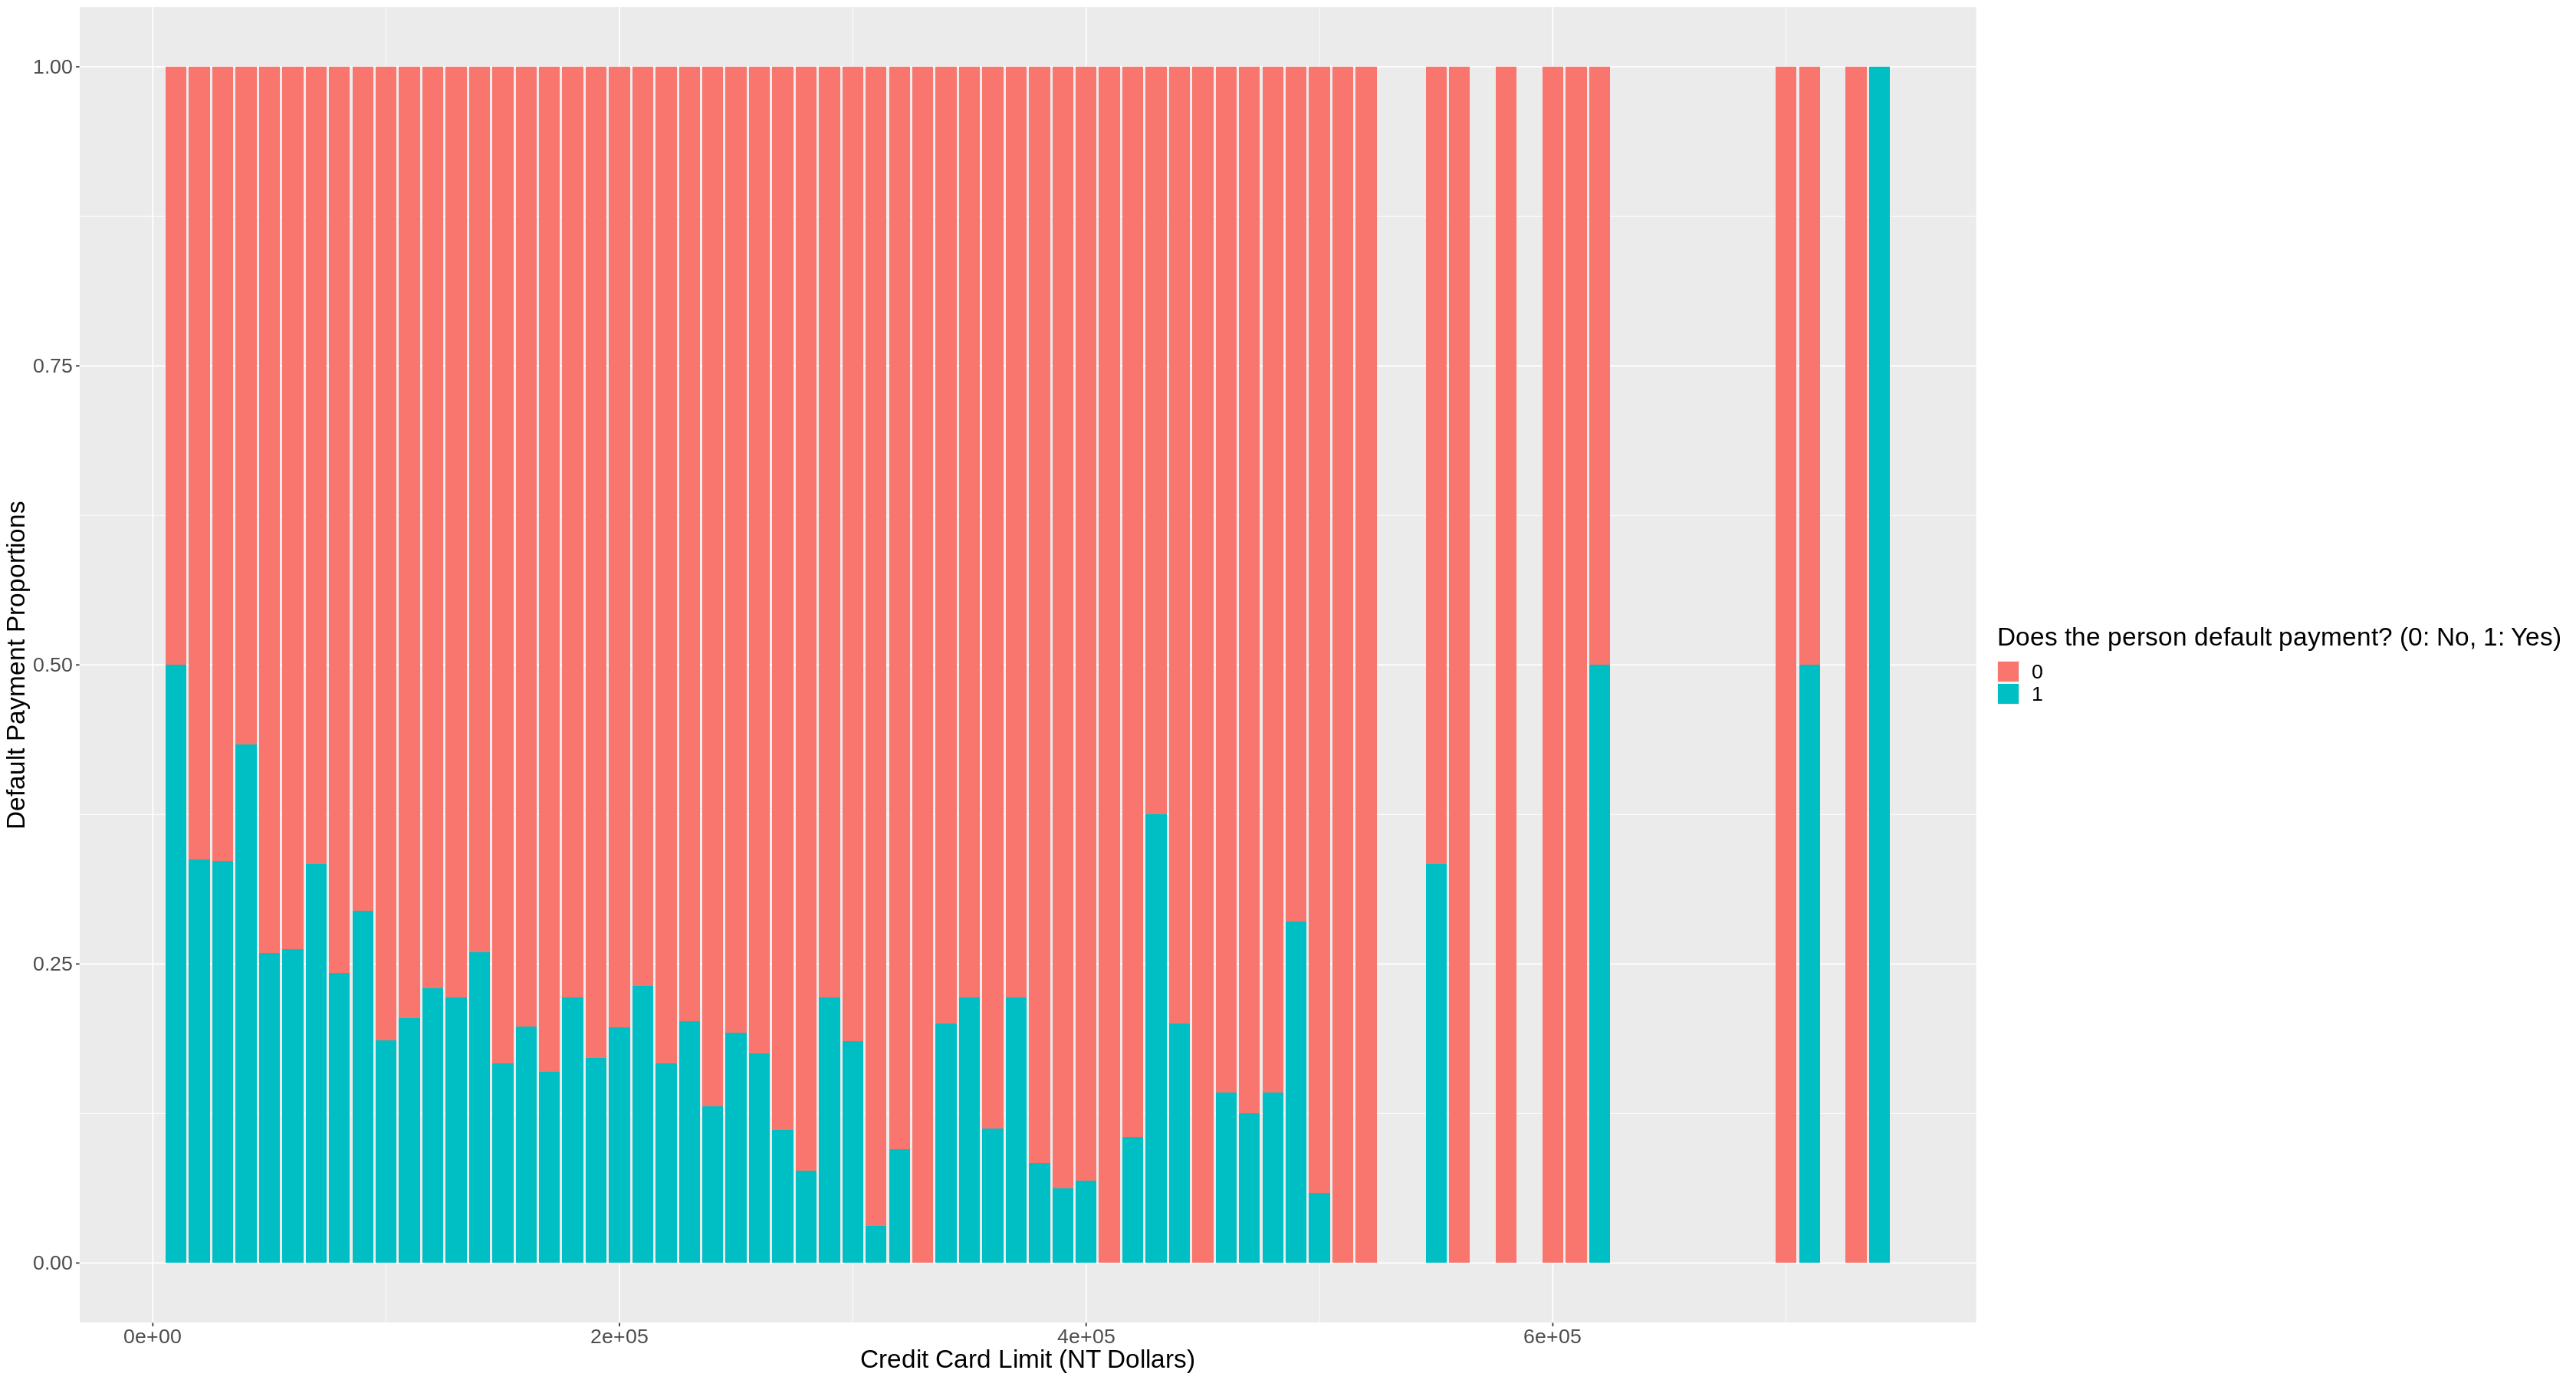

In [11]:
options(repr.plot.width = 28, repr.plot.height = 15)
bar_plot1 <- cd_5000_select %>%
   ggplot(aes(x = LIMIT_BAL, fill = default_nm)) + 
   geom_bar(position = 'fill') + 
   xlab("Credit Card Limit (NT Dollars)") +
   ylab("Default Payment Proportions") +
   labs(fill = "Does the person default payment? (0: No, 1: Yes)")+
   theme(text = element_text(size = 20))
bar_plot1

We can also see the number of people who default and don't based on their credit card limits next to each other by using the `plot_grid` function. 

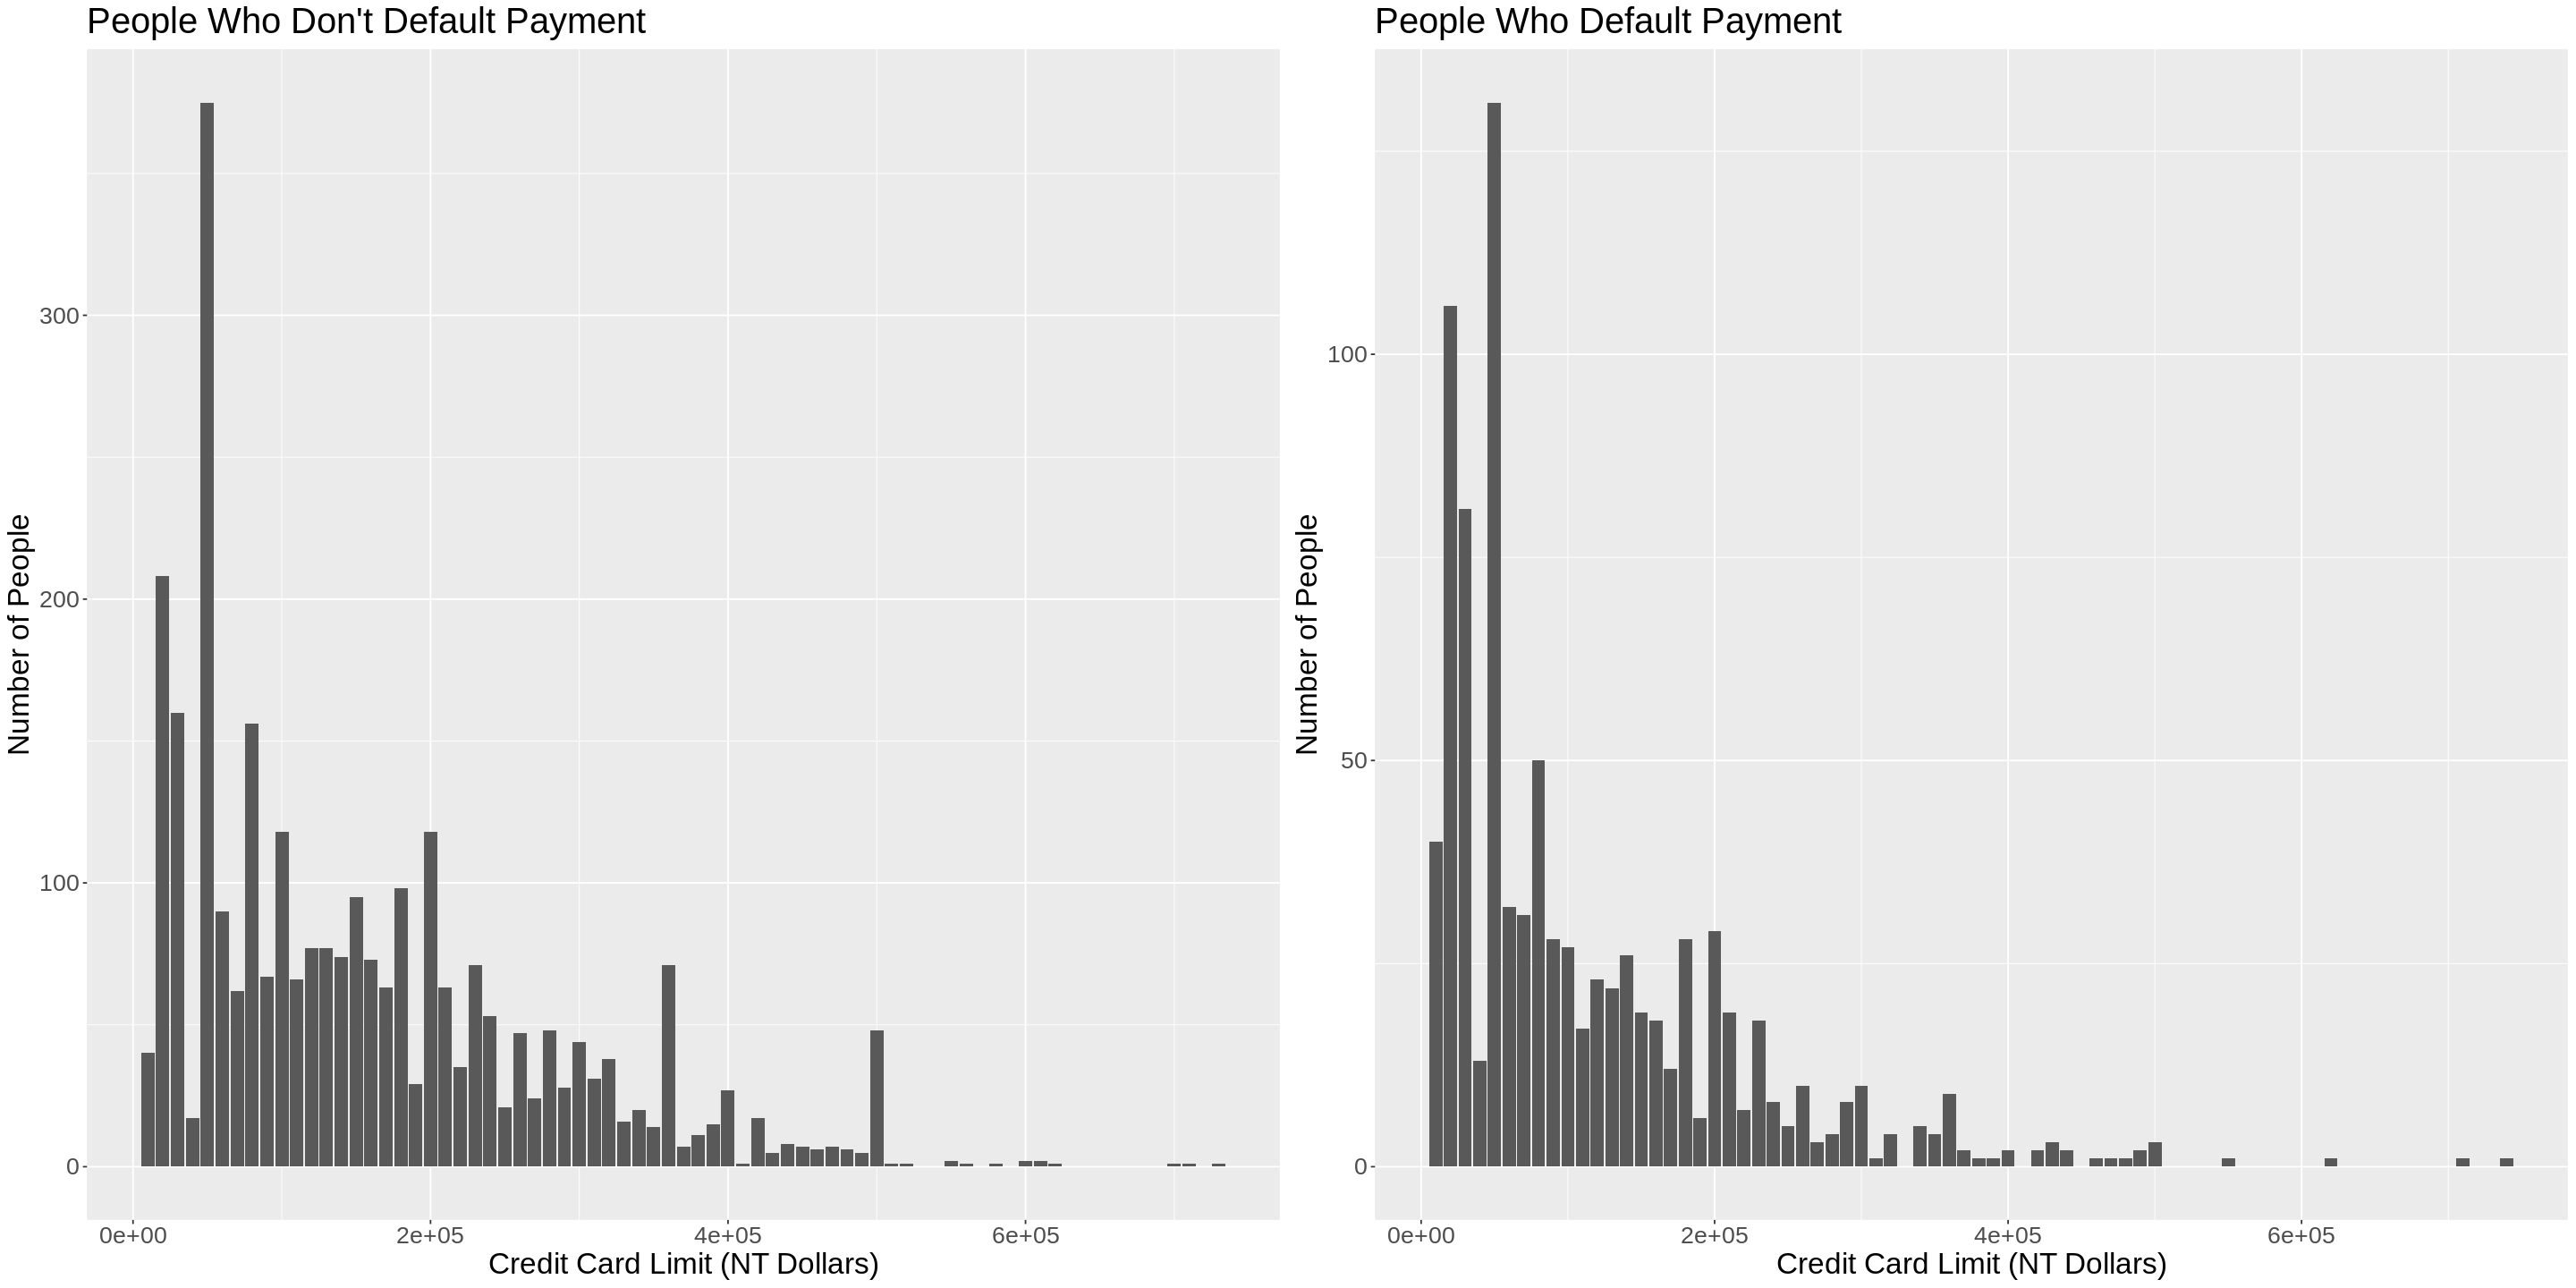

In [13]:
d1 <- filter(cd_5000, default_nm == 1)
d0 <- filter(cd_5000, default_nm ==0)

d1_bal <- d1 %>%
ggplot(aes(x=LIMIT_BAL)) +
geom_bar() +
ggtitle("People Who Default Payment") +
labs(x = "Credit Card Limit (NT Dollars)", y = "Number of People")+
theme(text = element_text(size = 20))

d0_bal <- d0 %>%
ggplot(aes(x=LIMIT_BAL)) +
geom_bar() +
ggtitle("People Who Don't Default Payment") +
labs(x = "Credit Card Limit (NT Dollars)", y = "Number of People")+
theme(text = element_text(size = 20))

plot_grid(d0_bal, d1_bal)

Here, we will look at one of our predictor variables, `PAY_0` which represents the payment status in September 2005 (the latest information available to us), -1 represents pay dully whereas x represents the payment delay for x months. This indicates that as the payment status `PAY_0` increases the proportion of people who default their payments also increases. 

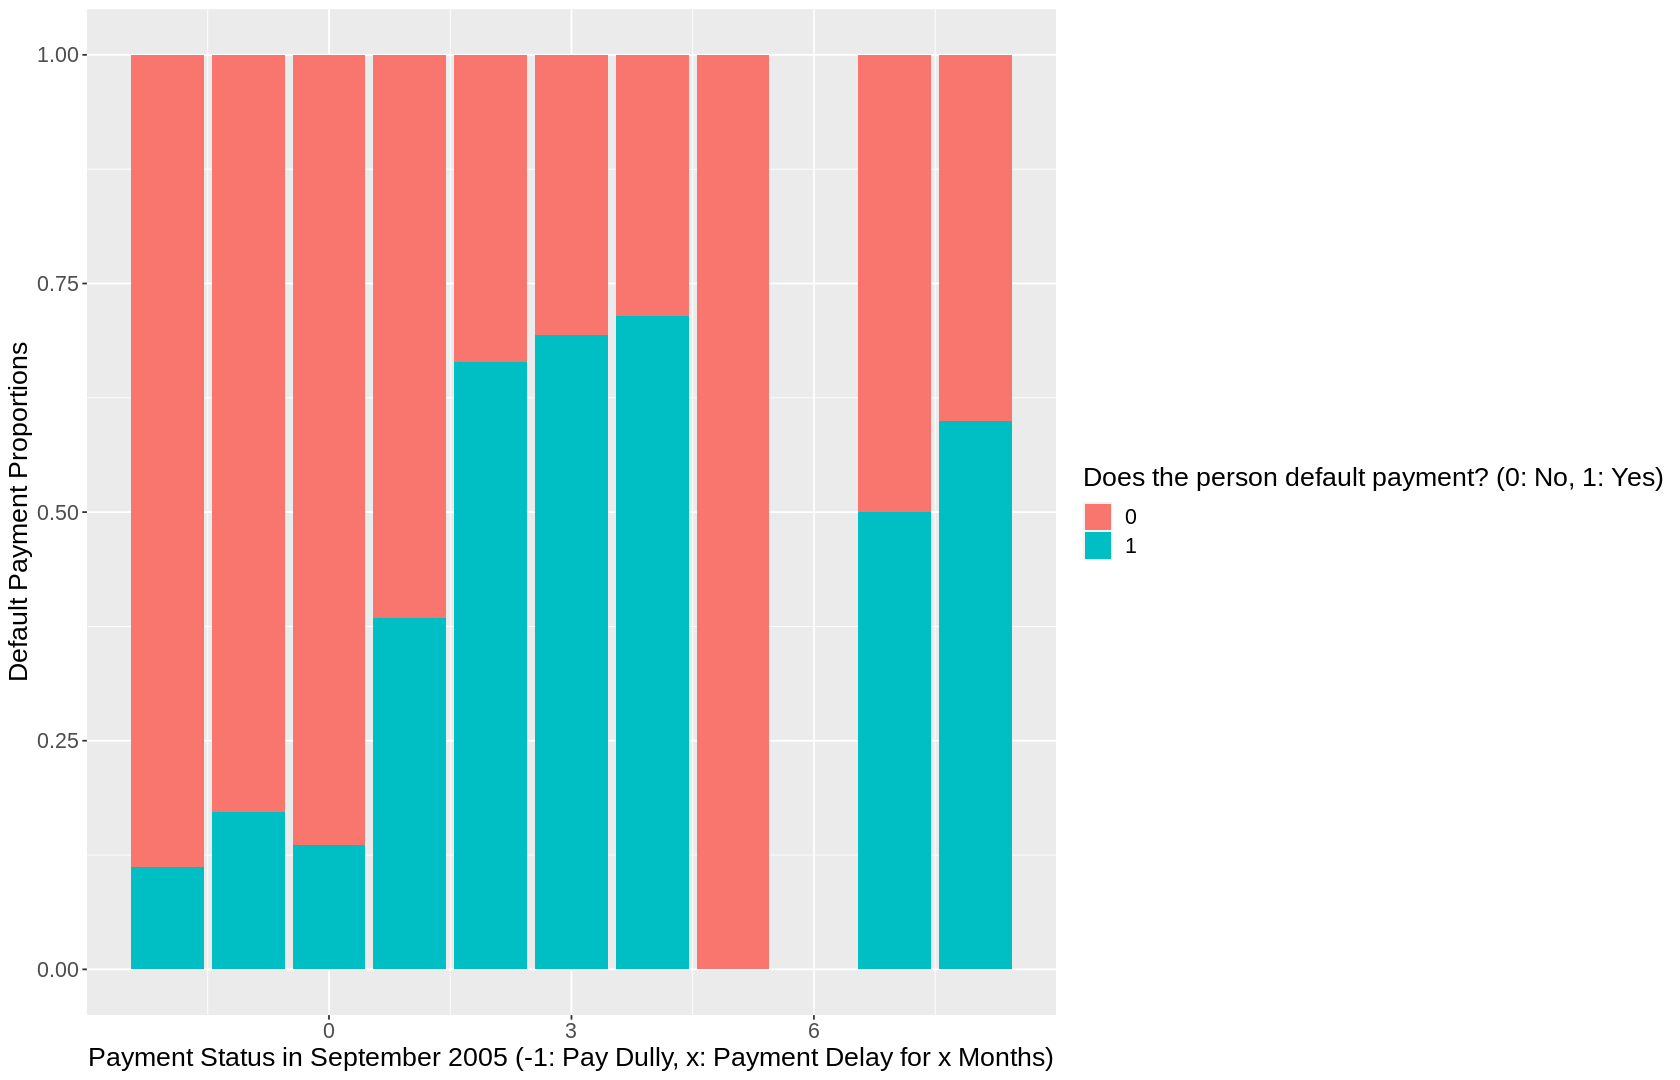

In [14]:
options(repr.plot.width = 14, repr.plot.height = 9) # GGOOOOODDDDDDDDDDDDDDDDDDDDDDD
bar_plot1 <- cd_5000_select %>%
   ggplot(aes(x = PAY_0, fill = default_nm)) + 
   geom_bar(position = 'fill') + 
   xlab("Payment Status in September 2005 (-1: Pay Dully, x: Payment Delay for x Months)") +
   ylab("Default Payment Proportions") +
   labs(fill = "Does the person default payment? (0: No, 1: Yes)")+
   theme(text = element_text(size = 16))
bar_plot1

# Methods 

We will conduct our analysis using a K nearest neighbors classification model with default payment representing our classification variable. For our predictors we will use `LIMIT_BAL`, `usage_cdt`, `pmt`, and `PAY_0` since they appear to be closely related to default as we will highlight below. Our data will consist of 5000 randomly selected observations of university educated individuals with 75% of the data making up the training set and the remaining 25% the testing. 


Cross-validation will be used to find the best K value for our classification model, and this will increase our model's accuracy. We will visualize the accuracy for K values as a line plot, and provide a table of metrics.

This plot below demonstrates the change in number of people who default their payments depending on the `PAY_0` variable. When `PAY_0` is more than 2 (a person delayed their payment more than 2 months in September 2005), they are more likely to default their payment, because we can see that there are more people who default than not for `PAY_0` >= 2. This makes `PAY_0` a strong predictor variable. 

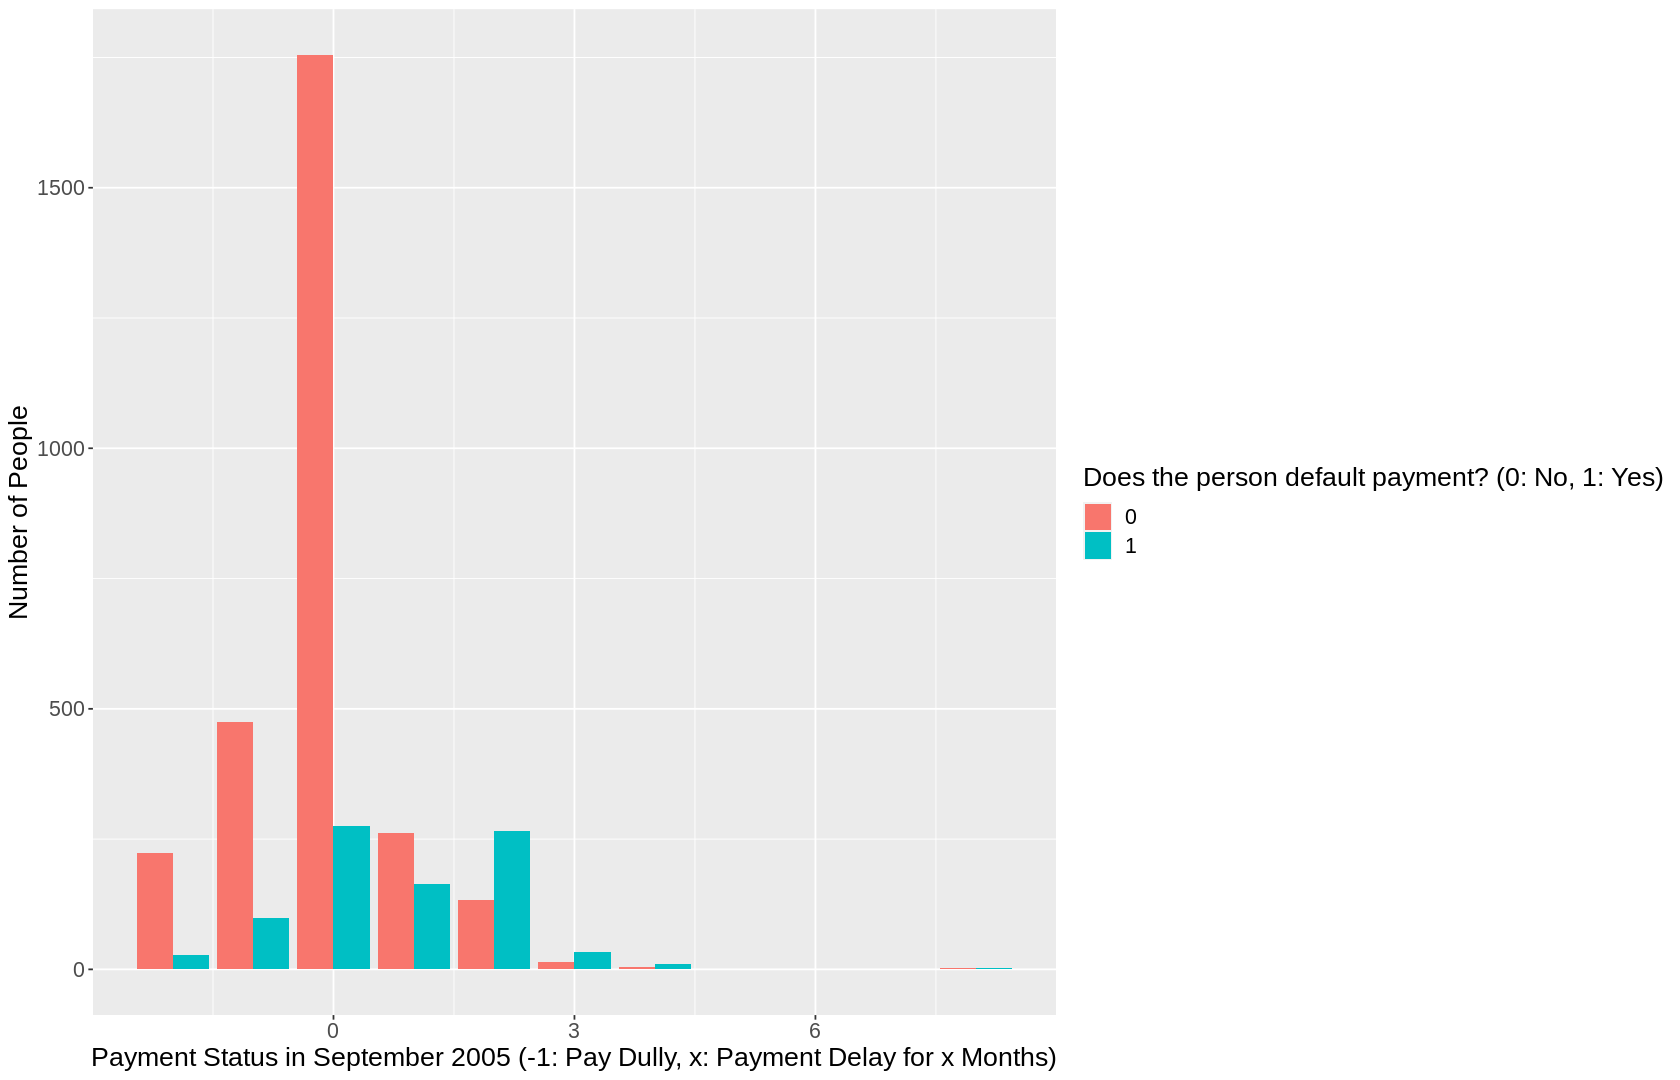

In [16]:
options(repr.plot.width = 14, repr.plot.height = 9)
bar_plot2 <- cd_5000 %>%
   ggplot(aes(x = PAY_0, fill = default_nm)) + 
   geom_bar(position = 'dodge') + 
   xlab("Payment Status in September 2005 (-1: Pay Dully, x: Payment Delay for x Months)") +
   ylab("Number of People") +
   labs(fill = "Does the person default payment? (0: No, 1: Yes)")+
   theme(text = element_text(size = 16))
bar_plot2

We can see that the number of people who default seem to consistently decrease as the credit limit increases. Therefore, this is a good predictor variable for our model. 

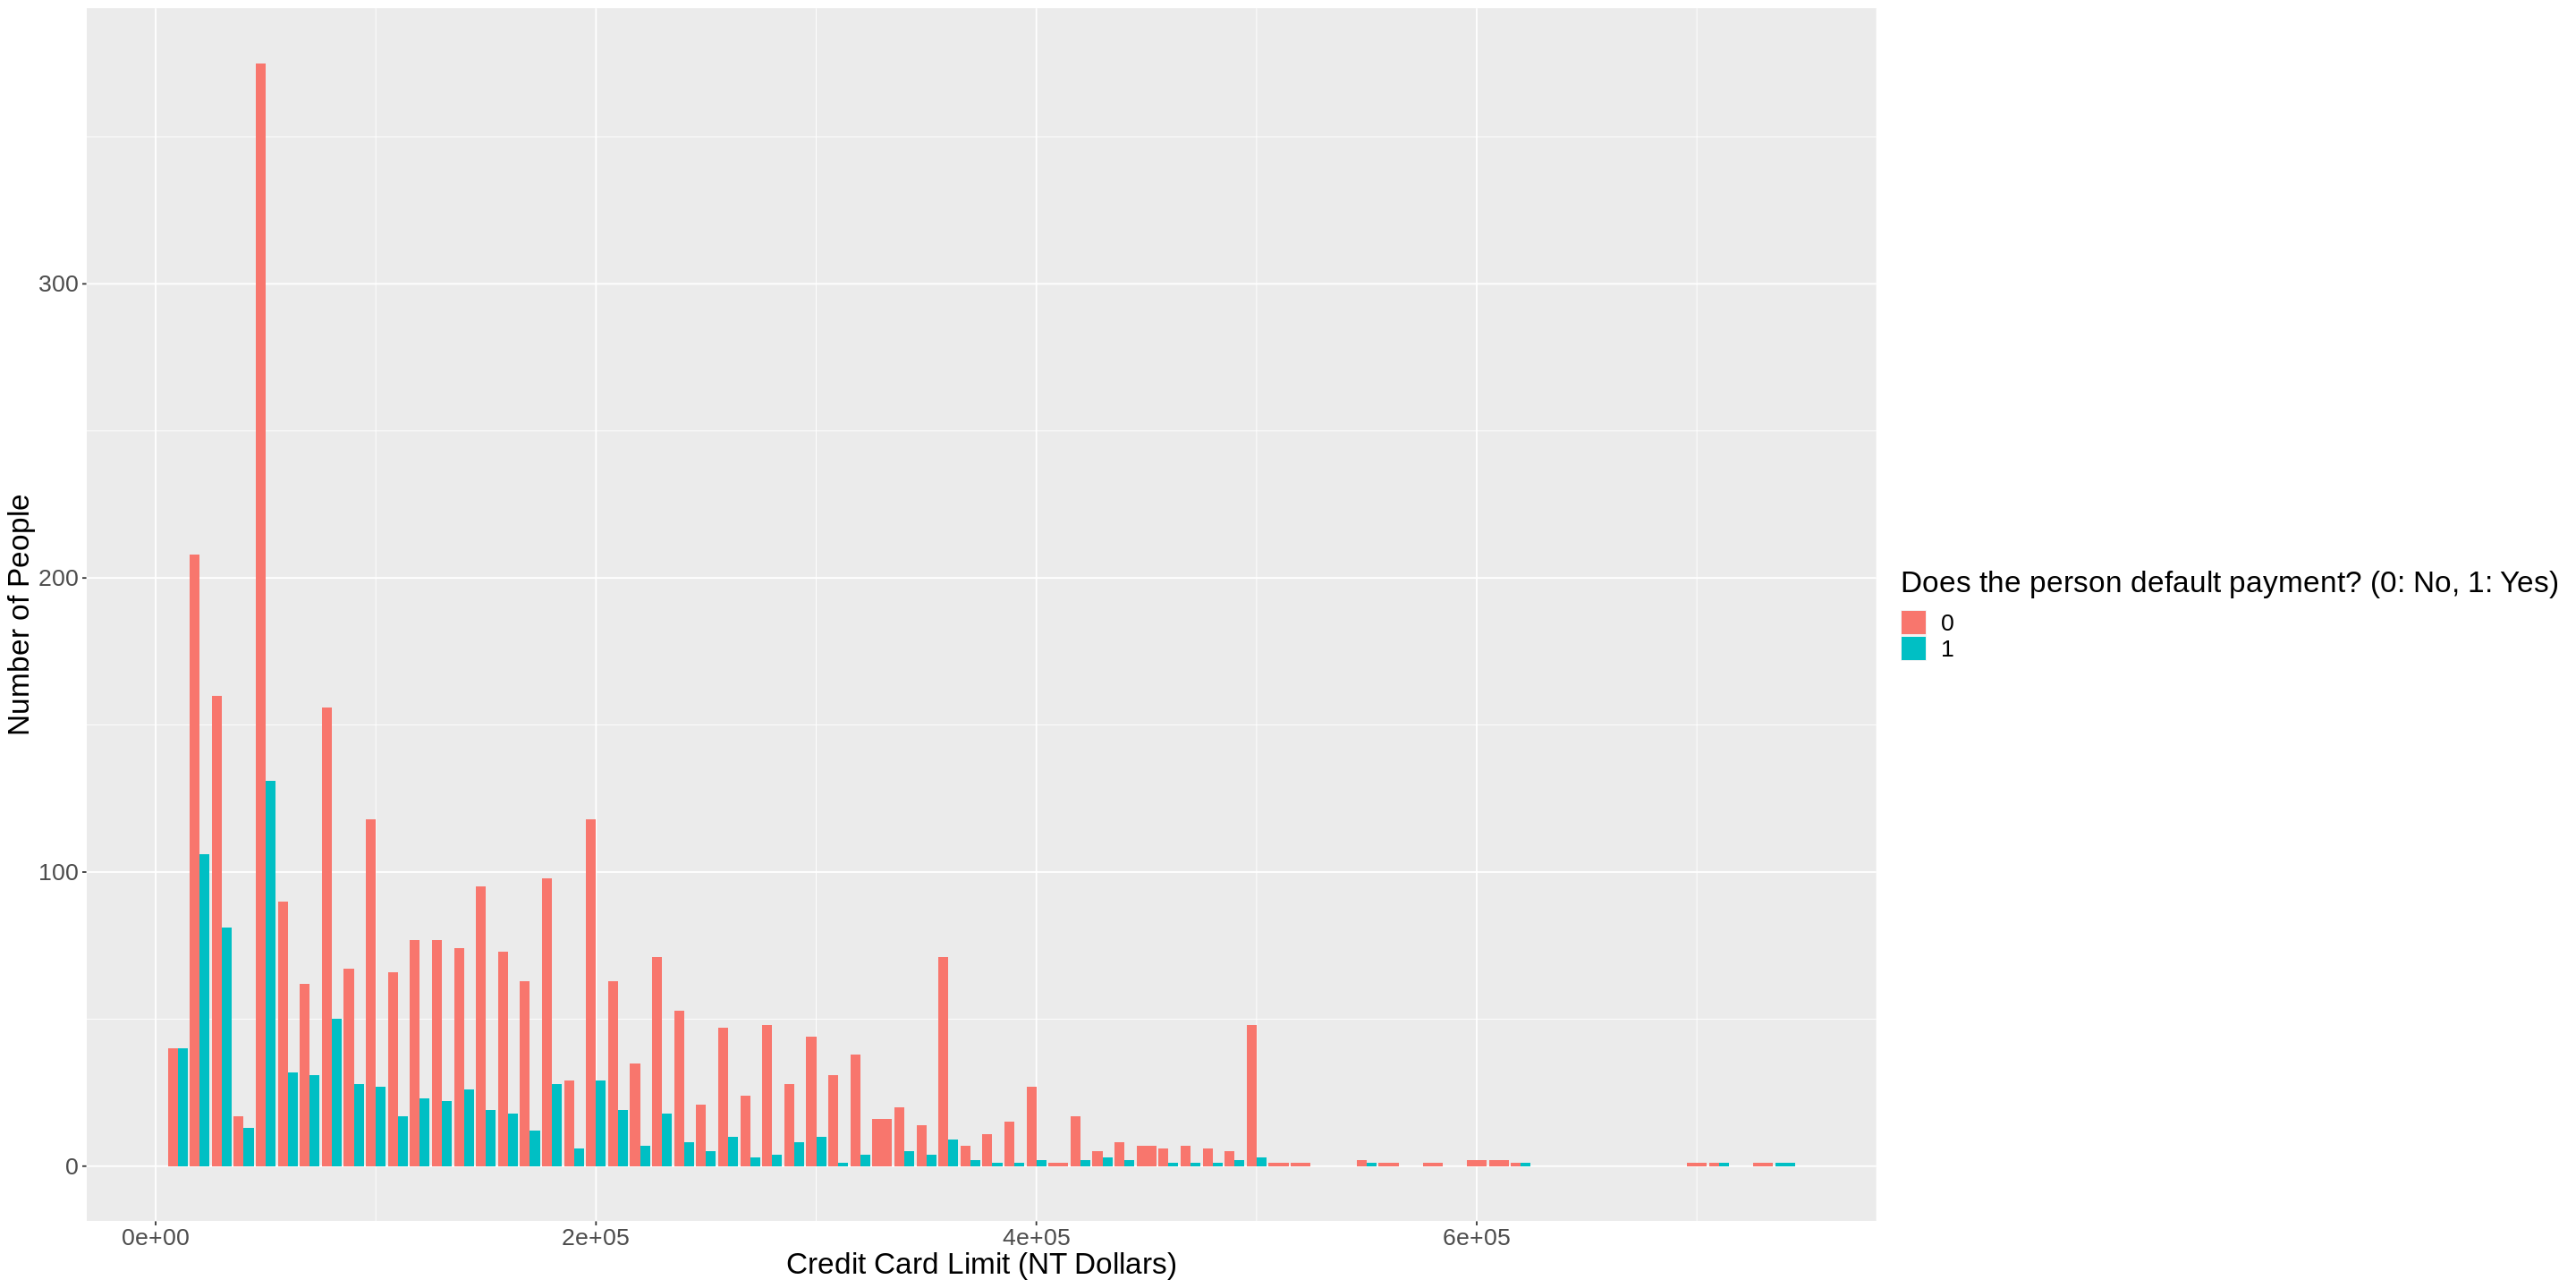

In [17]:
options(repr.plot.width = 24, repr.plot.height = 12)
bar_plot_bal <- cd_5000 %>%
   ggplot(aes(x = LIMIT_BAL, fill = default_nm)) + 
   geom_bar(position = 'dodge') + 
   xlab("Credit Card Limit (NT Dollars)") +
   ylab("Number of People") +
   labs(fill = "Does the person default payment? (0: No, 1: Yes)")+
   theme(text = element_text(size = 20))
bar_plot_bal

# Expected Outcomes and Significance 

We expect that our predictor variables `PAY_0`, `LIMIT_BAL`, `usage_cdt`, `pmt` will help us predict credit card default with reasonable accuracy.

Being able to accurately analyze credit risk and default payment is greatly beneficial for all involved parties since it limits an individual's debt to what is serviceable and limits potential loss for the financial organization.

This could lead to better assessment of credit risk, and therefore better assignment of credit limits on the part of financial institutions. This will reduce systemic financial risk among vulnerable populations of which credit card debt is a significant source of. If such a simple model can possess significant predictive power, what other kinds of data and predictive variables could be used to gain higher accuracy, and could this kind of prediction be extended to other asset classes?
